# Table of contents
1. [Understanding the data](#1)
2. [Feature Engineering](#2)
3. [Models](#3)
    1. [KMeans clustering](#3.1)
    2. [Isolation Forest](#3.2)
    3. [One class SVM](#3.3)

# 1) Understanding the data<a class="anchor" id="1"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('machine_data__002_.xls', parse_dates=['timestamp'], index_col='timestamp')

display(df.info())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22695 entries, 2013-12-02 21:15:00 to 2014-02-19 15:25:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   22695 non-null  float64
dtypes: float64(1)
memory usage: 354.6 KB


None

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


,value
timestamp,
2014-02-19 15:05:00,98.185415
2014-02-19 15:10:00,97.804168
2014-02-19 15:15:00,97.135468
2014-02-19 15:20:00,98.056852
2014-02-19 15:25:00,96.903861


**Observations:**
    1. 22695 rows without null
    2. Non-stop measurement from 2013-12-02 21:15:00 to 2014-02-19 15:25:00	
    3. time interval: 5mins

In [3]:
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


**Observations:**
    1. mean = 85.926498 -> I guess it is a temperture data in Fahrenheit ( Celsius = (Fahrenheit - 32)*5/9 )
    2. min = 2F (-16C) is non sense -> outlier exists
    3. max  = 108F (42C) makes sense
    4. 50% data laying within 28-34C (25% to 75%)

In [4]:
''' Convert from F to C '''
df.value = (df.value-32)*5/9

df.describe()

,value
count,22695.000000
mean,29.959166
std,7.637174
min,-16.619599
25%,28.377821
50%,31.893470
75%,34.453473
max,42.505857


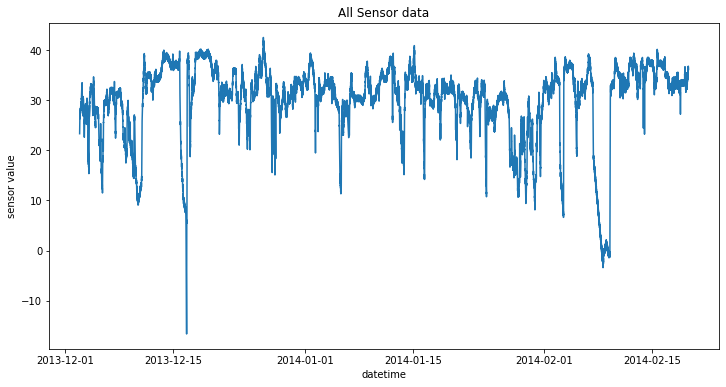

In [5]:
plt.figure(figsize=(12, 6))

plt.plot(df)
plt.title("All Sensor data")
plt.xlabel('datetime')
plt.ylabel('sensor value')
plt.show()

**Observations:**
    1. obvious anomaly (outliers) in 2013-12 (because it dropped to 0)
    2. protential outlier in 2014-02 (out of the 95% confidence interval)

# 2) Feature Engineering<a class="anchor" id="2"></a>

In [6]:
''' hours and if it's night or day (7:00-22:00) '''

df['hours'] = df.index.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [7]:
''' Day of the week (Monday=0, Sunday=6) and if it's a week end day or week day '''

df['DayOfTheWeek'] = df.index.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [8]:
df.head(5)

,value,hours,daylight,DayOfTheWeek,WeekDay
timestamp,,,,,
2013-12-02 21:15:00,23.315179,21,1,0,1
2013-12-02 21:20:00,23.853268,21,1,0,1
2013-12-02 21:25:00,24.513423,21,1,0,1
2013-12-02 21:30:00,25.633726,21,1,0,1
2013-12-02 21:35:00,26.294353,21,1,0,1


# 3) Models<a class="anchor" id="3"></a>

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [10]:
''' PCA '''

# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, columns=['PC1', 'PC2'])

In [11]:
data.head()

,PC1,PC2
0,-1.143708,-1.212546
1,-1.141072,-1.207525
2,-1.137839,-1.201365
3,-1.132351,-1.190911
4,-1.129115,-1.184746


## 3.1) KMeans clustering<a class="anchor" id="3.1"></a>

In [12]:
''' Elbow method '''

inertia = []

for n in range(1 , 11):
    kmeans = KMeans(n_clusters = n,
                    init = 'k-means++',   # initial cluster centers for k-mean clustering in a smart way to speed up convergence
                    random_state = 111,
                    algorithm = 'elkan')
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

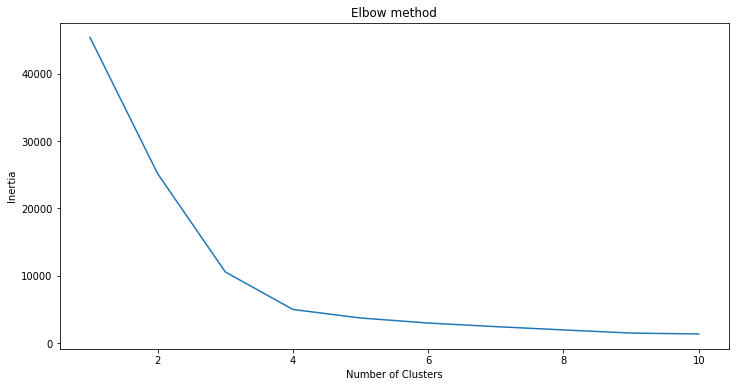

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1 , 11) , inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

**Observations:** n_clusters = 4

In [14]:
''' use n_clusters = 4 '''

kmeans_4 = KMeans(n_clusters = 4,
                init='k-means++',
                random_state= 111,
                algorithm='elkan')
kmeans_4.fit(data)

data['label'] = kmeans_4.labels_
centroids = kmeans_4.cluster_centers_

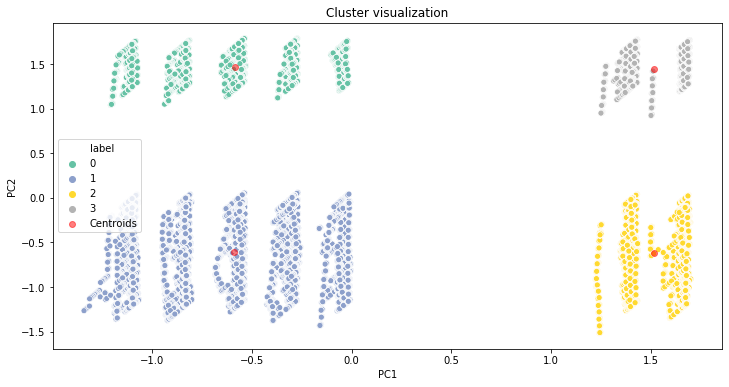

In [16]:
''' Cluster visualization '''

plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='PC1', y='PC2', hue='label', palette="Set2")
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], c='red', alpha=0.5, label='Centroids')

plt.title('Cluster visualization')
plt.legend(loc='center left')
plt.show()

In [16]:
''' Find anomaly by using the distance between cluster point and centroid '''

# Calculate distance between each point and its centroid
data['distance'] = data.apply\
(lambda row: np.sqrt((row.PC1 - centroids[int(row.label)][0])**2 + (row.PC2 - centroids[int(row.label)][1])**2), axis=1)

# Assume outliers_fraction = 0.02
outliers_fraction = 0.02

# Find the threshold
threshold = data['distance'].quantile(1-outliers_fraction)

# Find anomaly (0:normal, 1:anomaly) 
data['anomaly'] = data['distance'] >= threshold

In [17]:
data.head()

,PC1,PC2,label,distance,anomaly
0,-1.143708,-1.212546,1,0.823566,True
1,-1.141072,-1.207525,1,0.818079,True
2,-1.137839,-1.201365,1,0.811351,True
3,-1.132351,-1.190911,1,0.799943,True
4,-1.129115,-1.184746,1,0.793222,False


In [18]:
print('No. of anomaly:', len(data[data['anomaly']==1]))

No. of anomaly: 454


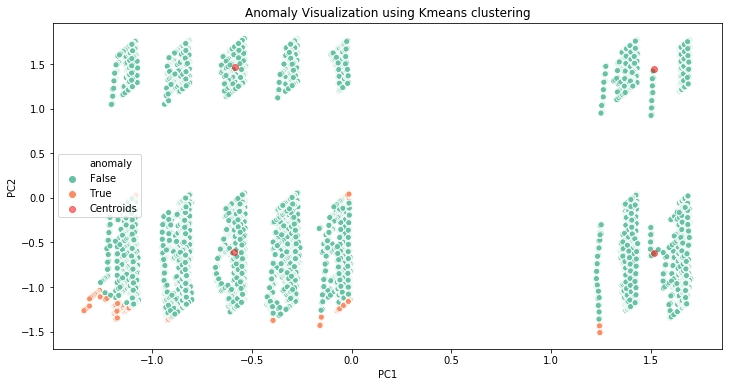

In [20]:
''' Anomaly Visualization by clusters '''

plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='PC1', y='PC2', hue='anomaly', palette="Set2")
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], c='red', alpha=0.5, label='Centroids')

plt.title('Anomaly Visualization using Kmeans clustering')
plt.legend(loc='center left')
plt.show()

In [20]:
df['anomaly_kmeans'] = np.array(data['anomaly'])

df.head()

,value,hours,daylight,DayOfTheWeek,WeekDay,anomaly_kmeans
timestamp,,,,,,
2013-12-02 21:15:00,23.315179,21,1,0,1,True
2013-12-02 21:20:00,23.853268,21,1,0,1,True
2013-12-02 21:25:00,24.513423,21,1,0,1,True
2013-12-02 21:30:00,25.633726,21,1,0,1,True
2013-12-02 21:35:00,26.294353,21,1,0,1,False


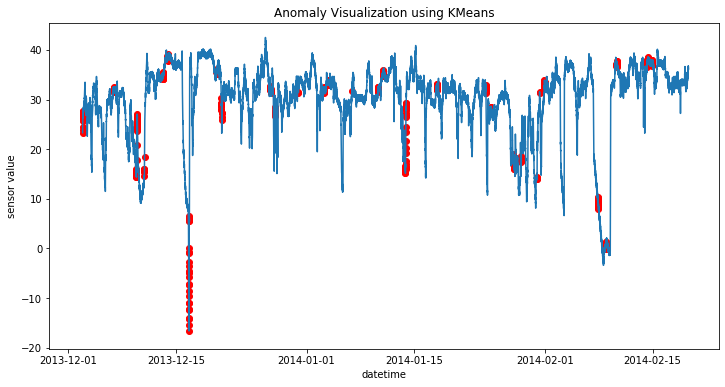

In [21]:
''' Anomaly Visualization by time-series '''

plt.figure(figsize=(12, 6))
plt.plot(df.value)
plt.scatter(x=df[df.anomaly_kmeans==1].index, y=df[df.anomaly_kmeans==1].value, color='r')

plt.title("Anomaly Visualization using KMeans")
plt.xlabel('datetime')
plt.ylabel('sensor value')
plt.show()

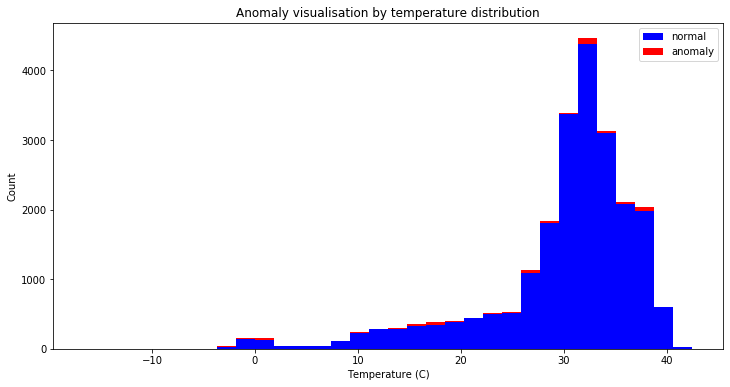

In [22]:
''' anomaly visualisation by temperature distribution '''

a = df.loc[df['anomaly_kmeans'] == 0, 'value']
b = df.loc[df['anomaly_kmeans'] == 1, 'value']

plt.figure(figsize=(12, 6))
plt.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

plt.title("Anomaly visualisation by temperature distribution")
plt.xlabel('Temperature (C)')
plt.ylabel('Count')
plt.legend()
plt.show()

## 3.2) Isolation Forest<a class="anchor" id="3.2"></a>

In [23]:
''' Take useful feature and standardize them '''

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, columns=data.columns)

In [24]:
data.head()

,value,hours,daylight,DayOfTheWeek,WeekDay
0,-0.869973,1.375415,0.709281,-1.484001,0.622342
1,-0.799515,1.375415,0.709281,-1.484001,0.622342
2,-0.713073,1.375415,0.709281,-1.484001,0.622342
3,-0.566379,1.375415,0.709281,-1.484001,0.622342
4,-0.479876,1.375415,0.709281,-1.484001,0.622342


In [25]:
''' train isolation forest '''

model =  IsolationForest(contamination = outliers_fraction)   # outliers_fraction = 0.01
model.fit(data)

IsolationForest(behaviour='old', bootstrap=False, contamination=0.02,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [26]:
''' Prediction '''

prediction = model.predict(data)
df['anomaly_isolationforest'] = prediction
df['anomaly_isolationforest'] = df['anomaly_isolationforest'].map( {1: 0, -1: 1} ).astype(bool)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [27]:
df.anomaly_isolationforest.value_counts()

False    22243
True       452
Name: anomaly_isolationforest, dtype: int64

In [28]:
df.head()

,value,hours,daylight,DayOfTheWeek,WeekDay,anomaly_kmeans,anomaly_isolationforest
timestamp,,,,,,,
2013-12-02 21:15:00,23.315179,21,1,0,1,True,False
2013-12-02 21:20:00,23.853268,21,1,0,1,True,False
2013-12-02 21:25:00,24.513423,21,1,0,1,True,False
2013-12-02 21:30:00,25.633726,21,1,0,1,True,False
2013-12-02 21:35:00,26.294353,21,1,0,1,False,False


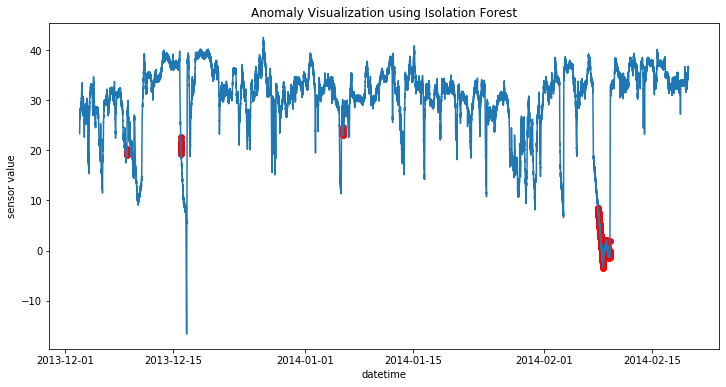

In [29]:
''' Anomaly Visualization by time-series '''

plt.figure(figsize=(12, 6))
plt.plot(df.value)
plt.scatter(x=df[df.anomaly_isolationforest==1].index, y=df[df.anomaly_isolationforest==1].value, color='r')

plt.title("Anomaly Visualization using Isolation Forest")
plt.xlabel('datetime')
plt.ylabel('sensor value')
plt.show()

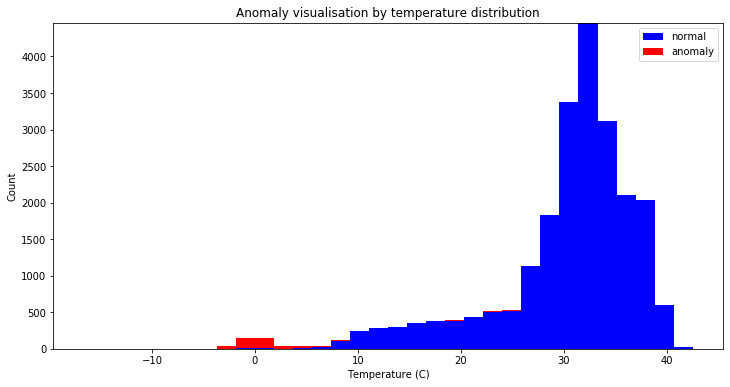

In [30]:
''' anomaly visualisation by temperature distribution '''

a = df.loc[df['anomaly_isolationforest'] == 0, 'value']
b = df.loc[df['anomaly_isolationforest'] == 1, 'value']

plt.figure(figsize=(12, 6))
plt.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

plt.title("Anomaly visualisation by temperature distribution")
plt.xlabel('Temperature (C)')
plt.ylabel('Count')
plt.legend()
plt.show()

## 3.3) One class SVM<a class="anchor" id="3.3"></a>

In [31]:
''' Take useful feature and standardize them '''

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, columns=data.columns)

In [32]:
data.head()

,value,hours,daylight,DayOfTheWeek,WeekDay
0,-0.869973,1.375415,0.709281,-1.484001,0.622342
1,-0.799515,1.375415,0.709281,-1.484001,0.622342
2,-0.713073,1.375415,0.709281,-1.484001,0.622342
3,-0.566379,1.375415,0.709281,-1.484001,0.622342
4,-0.479876,1.375415,0.709281,-1.484001,0.622342


In [33]:
''' train one class SVM '''

model =  OneClassSVM(nu=outliers_fraction)
model.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
            kernel='rbf', max_iter=-1, nu=0.02, random_state=None,
            shrinking=True, tol=0.001, verbose=False)

In [34]:
''' Prediction '''

prediction = model.predict(data)
df['anomaly_oneclassSVM'] = prediction
df['anomaly_oneclassSVM'] = df['anomaly_oneclassSVM'].map( {1: 0, -1: 1} ).astype(bool)

In [35]:
df['anomaly_oneclassSVM'].value_counts()

False    22241
True       454
Name: anomaly_oneclassSVM, dtype: int64

In [36]:
df.head()

,value,hours,daylight,DayOfTheWeek,WeekDay,anomaly_kmeans,anomaly_isolationforest,anomaly_oneclassSVM
timestamp,,,,,,,,
2013-12-02 21:15:00,23.315179,21,1,0,1,True,False,False
2013-12-02 21:20:00,23.853268,21,1,0,1,True,False,False
2013-12-02 21:25:00,24.513423,21,1,0,1,True,False,False
2013-12-02 21:30:00,25.633726,21,1,0,1,True,False,False
2013-12-02 21:35:00,26.294353,21,1,0,1,False,False,False


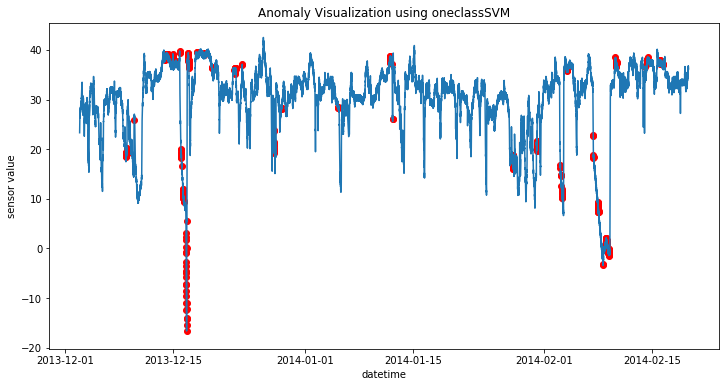

In [37]:
''' Anomaly Visualization by time-series '''

plt.figure(figsize=(12, 6))
plt.plot(df.value)
plt.scatter(x=df[df.anomaly_oneclassSVM==1].index, y=df[df.anomaly_oneclassSVM==1].value, color='r')

plt.title("Anomaly Visualization using oneclassSVM")
plt.xlabel('datetime')
plt.ylabel('sensor value')
plt.show()

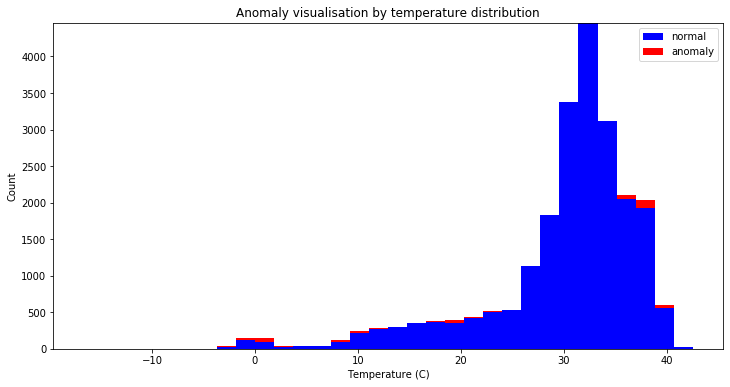

In [38]:
''' anomaly visualisation by temperature distribution '''

a = df.loc[df['anomaly_oneclassSVM'] == 0, 'value']
b = df.loc[df['anomaly_oneclassSVM'] == 1, 'value']

plt.figure(figsize=(12, 6))
plt.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

plt.title("Anomaly visualisation by temperature distribution")
plt.xlabel('Temperature (C)')
plt.ylabel('Count')
plt.legend()
plt.show()